# Diamonds Data Exploration

## Preliminary Wrangling
This document explores a dataset containing prices and attributes for approximately 54,000 round-cut diamonds.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe
diamonds = pd.read_csv('diamonds.csv')

In [3]:
# high-level overview of data shape and composition
print(diamonds.shape)
print(diamonds.dtypes)
diamonds.head(10)

(53940, 10)
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [4]:
# convert cut, color, and clarity into ordered categorical types
ordinal_var_dict = {'cut': ['Fair','Good','Very Good','Premium','Ideal'],
                    'color': ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                    'clarity': ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    diamonds[var] = diamonds[var].astype(ordered_var)

In [5]:
# descriptive statistics for numeric variables
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


### What is the structure of your dataset?
There are 53,940 diamonds in the dataset with 10 features (carat, cut, color, clarity, depth, table, price, x, y, and z). Most variables are numeric in nature, but the variables cut, color, and clarity are ordered factor variables with the following levels.

(worst) ——> (best)<br/>
cut: Fair, Good, Very Good, Premium, Ideal<br/>
color: J, I, H, G, F, E, D<br/>
clarity: I1, SI2, SI1, VS2, VS1, VVS2, VVS1, IF<br/>

### What is/are the main feature(s) of interest in your dataset?
I'm most interested in figuring out what features are best for predicting the price of the diamonds in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
I expect that carat will have the strongest effect on each diamond's price: the larger the diamond, the higher the price. I also think that the other big "C"s of diamonds: cut, color, and clarity, will have effects on the price, though to a much smaller degree than the main effect of carat.

## Univariate Exploration

I will start by looking at the main variable of interest: price. 

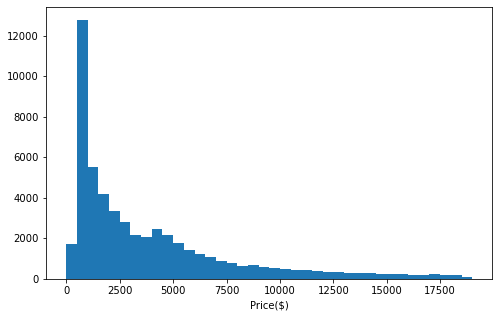

In [6]:
# start with a standard-scaled plot
binsize = 500
bins = np.arange(0, diamonds['price'].max()+binsize, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=diamonds, x='price', bins=bins)
plt.xlabel('Price($)')
plt.show()

Price distribution comment 1: You should create a histogram for price, since it is a numeric variable. Your initial plots should show that diamond price follows a highly skewed distribution. If you haven't tried a log scaling, then try that now.

In [7]:
np.log10(diamonds['price'].describe())

count    4.731911
mean     3.594702
std      3.600912
min      2.513218
25%      2.977724
50%      3.380392
75%      3.726258
max      4.274689
Name: price, dtype: float64

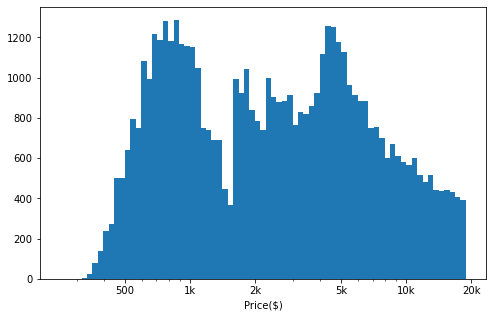

In [8]:
# there is a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10**np.arange(2.4, np.log10(diamonds['price'].max()) + log_binsize, log_binsize)

plt.figure(figsize=[8,5])
plt.hist(data=diamonds, x='price', bins=bins)
plt.xscale('log')

ticks = [500, 1e3, 2e3, 5e3, 1e4, 2e4]
labels = [500, '1k', '2k', '5k', '10k', '20k']
plt.xticks(ticks, labels)
plt.xlabel('Price($)')
plt.show()

Price has a long-tailed distribution, with a lot of diamonds on the low price end, and few on the high price end. When plotted on a log-scale, the price distribution looks roughly bimodal, with one peak between 500 and 1000, and a second peak a little below 5000. Interestingly, there's a steep jump in frequency right before 2000, rather than a smooth ramp up.

Next up, the first predictor variable of interest, our first diamond 'C' metric: carat weight. 

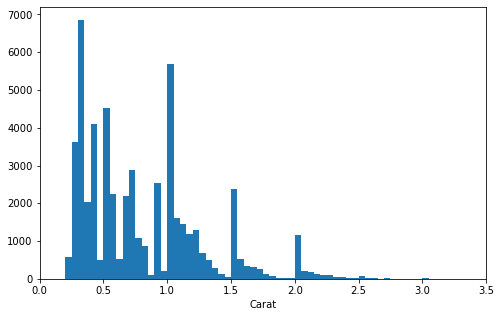

In [9]:
# plotting carat on a standard scale
binsize = 0.05
bins = np.arange(0, diamonds['carat'].max()+binsize, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=diamonds, x='carat', bins=bins)
plt.xlim(0, 3.5)
plt.xlabel('Carat');

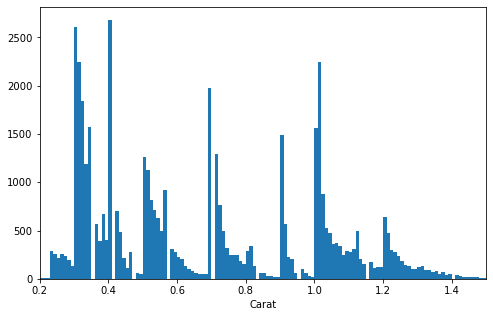

In [10]:
# investigating further on an even smaller bin size
binsize = 0.01
bins = np.arange(0, diamonds['carat'].max()+binsize, binsize)

plt.figure(figsize=[8,5])
plt.hist(data=diamonds, x='carat', bins=bins)
plt.xlim(0.2, 1.5)
plt.xlabel('Carat');

In [11]:
np.log10(diamonds['carat'].describe())

count    4.731911
mean    -0.098030
std     -0.324211
min     -0.698970
25%     -0.397940
50%     -0.154902
75%      0.017033
max      0.699838
Name: carat, dtype: float64

In the case of carat, the small bin size proves very illuminating. There are very large spikes in frequency at the bars with one digit of precision (e.g. 0.3, 0.7, 1.0), frequency quickly trails off until the next spike. These probably represent standard diamond sizes for use in jewelry.

Now, let's move on to exploring the other three 'C' quality measures: cut, color, and clarity. 

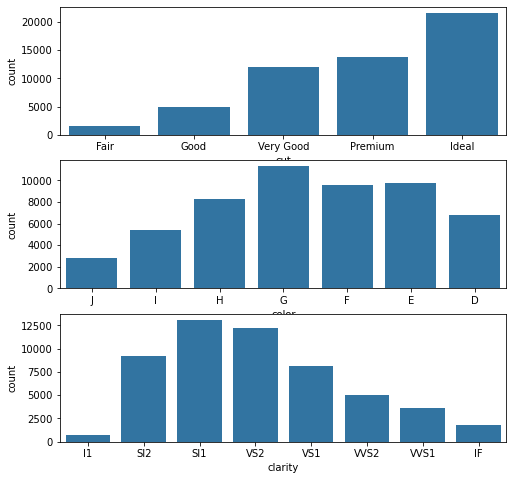

In [12]:
# let's plot all three together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=3, figsize=[8,8])

base_color = sb.color_palette()[0]
sb.countplot(data=diamonds, x='cut', color=base_color, ax=ax[0])
sb.countplot(data=diamonds, x='color', color=base_color, ax=ax[1])
sb.countplot(data=diamonds, x='clarity', color=base_color, ax=ax[2])

plt.show();

The cut quality of the diamonds in the dataset is generally quite good, with most of them in the Premium or Ideal level. Most of the diamonds are also of color quality G or better. Clarity, shows a trend opposite from the other two features, with most of the diamonds on the lower end of the scale, at VS2 or worse. Clarity grades become rarer as steps are taken up the scale.

I'll now look at the other features in the data to se if any of them hold interesting properties.

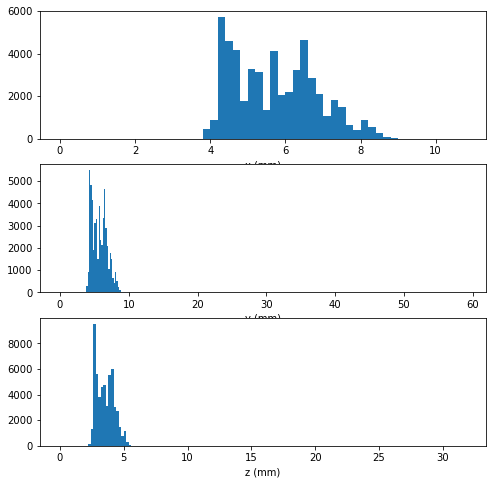

In [13]:
# let's start with the major dimensions of the diamonds, with x, y and z

fig, ax = plt.subplots(nrows=3, figsize=[8,8])

variables=['x','y','z']
for i in range(len(variables)):
    var = variables[i]
    bins = np.arange(min(diamonds[var]), max(diamonds[var])+0.2, 0.2)
    ax[i].hist(data=diamonds, x=var, bins=bins)
    ax[i].set_xlabel('{} (mm)'.format(var))
    
plt.show()

The initial plot of the x, y and z features show some immediate points of attention. On the y an z plots, most of the data is set to be far left of their axes, suggesting some strong outliers on the right. The left limits of all three plots also suggest that there are some points that take unusually small values. It's worth taking a bit of time to identify these outliers and see if they need to be filtered out of the data.

In [14]:
# select low outliers, using criteria eyeballed from the plots

low_outliers = (diamonds['x'] < 3.5) | (diamonds['y'] < 3.5) | (diamonds['z'] < 2)

print(low_outliers.sum())
print(diamonds.loc[low_outliers, :])

23
       carat        cut color clarity  depth  table  price     x     y     z
2207    1.00    Premium     G     SI2   59.1   59.0   3142  6.55  6.48  0.00
2314    1.01    Premium     H      I1   58.1   59.0   3167  6.66  6.60  0.00
4791    1.10    Premium     G     SI2   63.0   59.0   3696  6.50  6.47  0.00
5471    1.01    Premium     F     SI2   59.2   58.0   3837  6.50  6.47  0.00
10167   1.50       Good     G      I1   64.0   61.0   4731  7.15  7.04  0.00
11182   1.07      Ideal     F     SI2   61.6   56.0   4954  0.00  6.62  0.00
11963   1.00  Very Good     H     VS2   63.3   53.0   5139  0.00  0.00  0.00
13601   1.15      Ideal     G     VS2   59.2   56.0   5564  6.88  6.83  0.00
14635   1.07      Ideal     F     SI1   60.6   57.0   5909  6.62  6.67  1.07
15951   1.14       Fair     G     VS1   57.5   67.0   6381  0.00  0.00  0.00
20694   1.53      Ideal     I     SI1   61.9   54.0   8971  7.43  7.50  1.53
21654   1.41      Ideal     H     VS1   60.7   56.0   9752  7.31  7.22  1

There are 23 outliers with unusually low values for x, y or z. Most of them have a 0 value for z, some of them also have a 0 value for x or y. The three diamonds that don't have a 0 value  have a z-value that actually matches their carat instead. There might have been an error in data input. Interestingly, these diamonds tend to be fairly high in price, most of them above the median and over half above the third quartile.

In [15]:
# select high outliers, using criteria eyeballed from the plots

high_outliers = (diamonds['y'] > 10) | (diamonds['z'] > 6)

print(high_outliers.sum())
print(diamonds.loc[high_outliers, :])

15
       carat        cut color clarity  depth  table  price      x      y  \
23644   3.65       Fair     H      I1   67.1   53.0  11668   9.53   9.48   
24067   2.00    Premium     H     SI2   58.9   57.0  12210   8.09  58.90   
24328   3.50      Ideal     H      I1   62.8   57.0  12587   9.65   9.59   
25998   4.01    Premium     I      I1   61.0   61.0  15223  10.14  10.10   
25999   4.01    Premium     J      I1   62.5   62.0  15223  10.02   9.94   
26194   2.01       Fair     G     SI2   65.6   56.0  15562   7.89   7.84   
26431   3.40       Fair     D      I1   66.8   52.0  15964   9.42   9.34   
26444   4.00  Very Good     I      I1   63.3   58.0  15984  10.01   9.94   
26534   3.67    Premium     I      I1   62.4   56.0  16193   9.86   9.81   
27130   4.13       Fair     H      I1   64.8   61.0  17329  10.00   9.85   
27415   5.01       Fair     J      I1   65.5   59.0  18018  10.74  10.54   
27630   4.50       Fair     J      I1   65.8   58.0  18531  10.23  10.16   
27679   3

Most of the high outliers appear to be valid points, with the exception of the three points with extreme values in the y and z variables. As a final outlier check, since "table" is the ratio of z to the average of x an dy ((2*z)/(x+y)), we can see how many points do not have a matching calculated value.

In [16]:
# select points whose depth value does not match x, y and z values

incorrect_depth = (np.abs(2 * diamonds['z'] / (diamonds['x'] + diamonds['y']) - diamonds['depth']/100) > 0.1)
no_size_info = ((diamonds['x'] == 0) & (diamonds['y'] == 0))
print(diamonds.loc[incorrect_depth | no_size_info, ['carat', 'depth', 'x', 'y', 'z']])

       carat  depth     x      y      z
2207    1.00   59.1  6.55   6.48   0.00
2314    1.01   58.1  6.66   6.60   0.00
2941    1.00   62.8  6.26   6.19   3.19
4518    1.00   43.0  6.32   6.27   3.97
4791    1.10   63.0  6.50   6.47   0.00
5471    1.01   59.2  6.50   6.47   0.00
6341    1.00   44.0  6.31   6.24   4.12
10167   1.50   64.0  7.15   7.04   0.00
10377   1.09   43.0  6.53   6.55   4.12
11182   1.07   61.6  0.00   6.62   0.00
11963   1.00   63.3  0.00   0.00   0.00
13601   1.15   59.2  6.88   6.83   0.00
14635   1.07   60.6  6.62   6.67   1.07
15951   1.14   57.5  0.00   0.00   0.00
19502   1.57   67.3  7.85   5.75   3.87
20694   1.53   61.9  7.43   7.50   1.53
21654   1.41   60.7  7.31   7.22   1.41
24067   2.00   58.9  8.09  58.90   8.06
24394   2.18   59.4  8.49   8.45   0.00
24520   1.56   62.2  0.00   0.00   0.00
25849   2.00   59.0  6.16   6.15   4.82
26123   2.25   61.3  8.52   8.42   0.00
26194   2.01   65.6  7.89   7.84   6.16
26243   1.20   62.1  0.00   0.00   0.00


This check captures not only the 26 outliers that were identified above, but a number of other points that had conflicting information. For safety, I'll remove all of these inconsistent points from the data. Then, I'll recreate the plots of x, y and z.

In [17]:
# remove points with inconsistent depth values
diamonds = diamonds.loc[-incorrect_depth & -no_size_info, :]

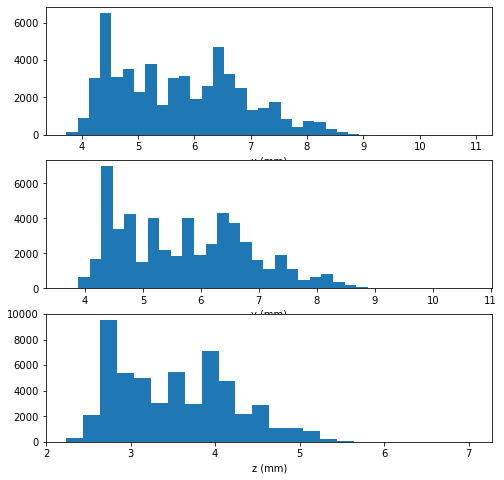

In [18]:
# re-plot the distribution of x, y and z
fig, ax = plt.subplots(nrows=3, figsize=[8,8])

variables=['x','y','z']
for i in range(len(variables)):
    var = variables[i]
    bins = np.arange(min(diamonds[var]), max(diamonds[var])+0.2, 0.2)
    ax[i].hist(data=diamonds, x=var, bins=bins)
    ax[i].set_xlabel('{} (mm)'.format(var))
    
plt.show()

Interestingly, the shape of the x, y and z distributions are very similar to one another. The z distribution just looks slightly different since it takes a smaller range of values, and so the bins are larger in a relative sense. It's likely that these variables will be highly correlated with one another, and probably have a strong correlation with carat.

We will also look at the last two variables: depth and table.

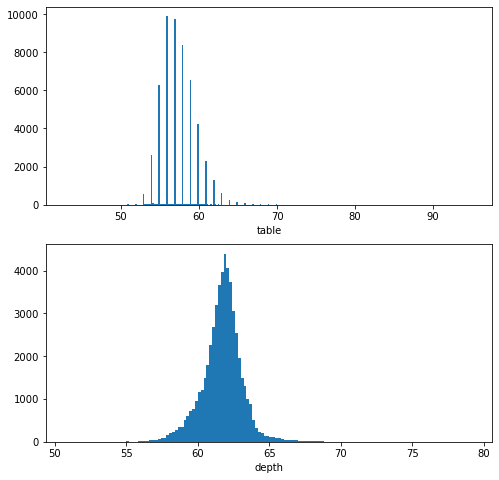

In [19]:
fig, ax = plt.subplots(nrows=2, figsize=[8,8])

variables=['table', 'depth']
for i in range(len(variables)):
    var = variables[i]
    bins = np.arange(min(diamonds[var]), max(diamonds[var])+0.2, 0.2)
    ax[i].hist(data=diamonds, x=var, bins=bins)
    ax[i].set_xlabel('{}'.format(var))
    
plt.show()

Both table and depth are unimodal, but the distributions are slightly skewed and look a little narrower than a normal distribution. Table is slightly skewed right, while depth is slightly skewed left. I wonder if they'are negatively correlated. Table is also a discrete numberic variable.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any tranformations?

The price variable took on a large range of values, so I looked at the data using a log transform. Under the transformation, the data looked bimodal, with one peak between \\$500 and \\$1000, and another just below \\$5000.

### Of other features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

When investigating the x, y and z size variables, a number of outlier points were identified. Overall, these points can be characterized by an inconsistency between the recorded value of depth, and the value that would be derived from using x, y and z. For safety, all of these points were removed from the dataset to move forwards.

## Bivariate Exploration

To start off with, I want to look at the pairwise correlations present betweeen features in the data.

In [20]:
numeric_vars = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']
categoric_vars = ['cut', 'color', 'clarity']

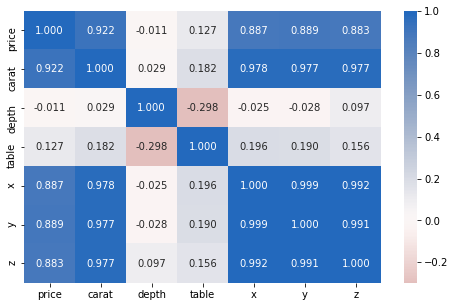

In [21]:
# correlation plot
plt.figure(figsize=[8, 5])
sb.heatmap(diamonds[numeric_vars].corr(), annot=True, fmt='.3f', cmap='vlag_r', center=0)
plt.show()

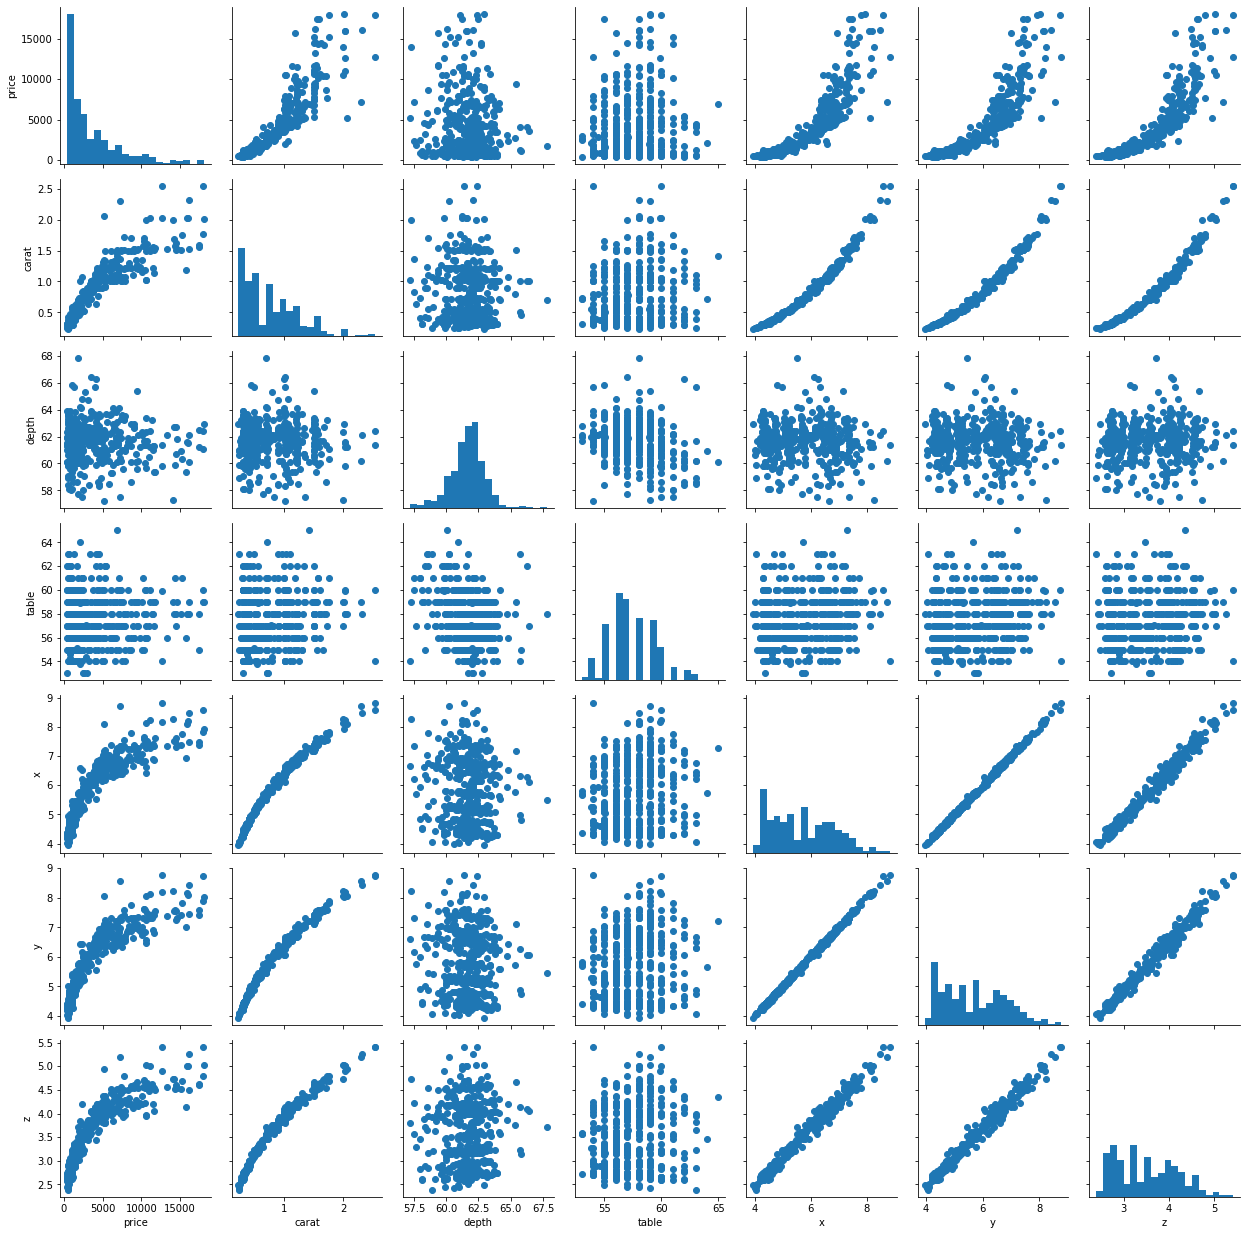

In [22]:
# plot matrix: sample 500 diamonds so that plots are clearer and they render faster

samples = np.random.choice(diamonds.shape[0], 500, replace=False)
diamonds_samp = diamonds.loc[samples, :]

g = sb.PairGrid(data=diamonds_samp, vars=numeric_vars)
g.map_diag(plt.hist, bins=20)
g.map_offdiag(plt.scatter)

As expected, the 'x', 'y' and 'z' dimensions are all highly correlated with one another, and all of them are also highly correlated with carat. Since carat is a measure of diamond size, it's not too surprising that the overall trend between carat and the three individual dimensions appears polynomial. In addition, since all the diamonds are round-cut, it makes sense that the 'x', 'y' and 'z' sizess would all move proportionally together.

Surprisingly, the correlation coefficient between price and carat is very high, despite the fact that price has such a larger range of values. This will be worth extra exploration in this section. Depth and table don't have strong correlations with any other numeric variables in the dataset, and we see the moderate negative correlation hypothesized in the previous section. I won't perform any further analyses with these variables since they don't look like they will be of much further interest.

Let's move on to looking at how price and carat weight correlate with the categorical variables.

D:\Users\Pototo\anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
D:\Users\Pototo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\Pototo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Users\Pototo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.

<Figure size 720x720 with 0 Axes>

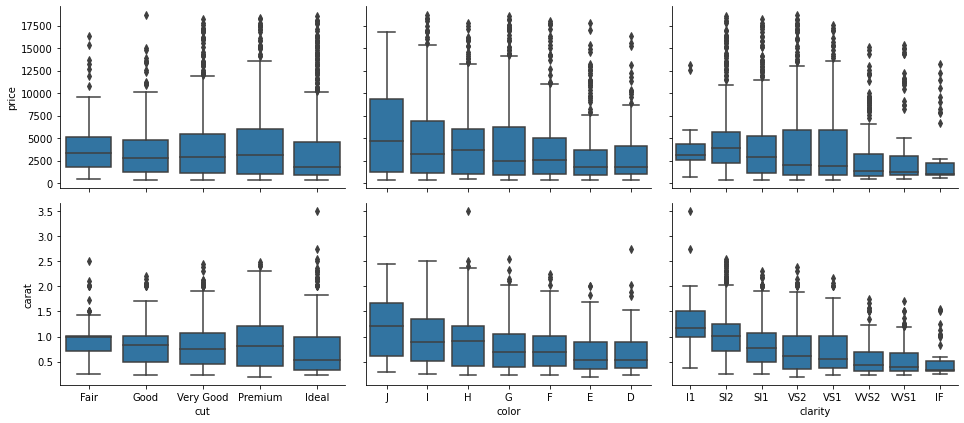

In [26]:
# plot matrix of numeric features against categorical features
# can use a large sample since there are fewer plots and they are simpler in nature

samples = np.random.choice(diamonds.shape[0], 2000, replace=False)
diamonds_samp = diamonds.reindex(samples)

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    base_color = sb.color_palette()[0]
    sb.boxplot(x, y, color=base_color)
    
plt.figure(figsize=[10,10])
g = sb.PairGrid(data=diamonds_samp, y_vars = ['price', 'carat'], x_vars = categoric_vars, size=3, aspect = 1.5)
g.map(boxgrid)
plt.show();

Interestingly, it appears that there are some negative relationships between the categorical variables and the two numeric variables of interest. The diamonds with the best features (Ideal cut, color D, clarity IF) seem to get the lowest prices, but also tend to be smaller on average. This will be worth investigating more later on, using the full data.

Finally, let's look at the relationships between the three categorical features.

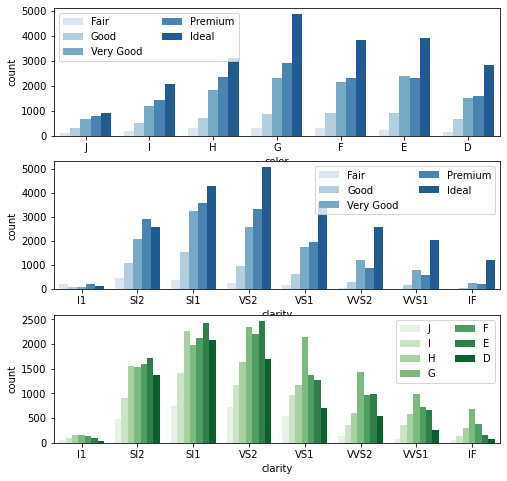

In [31]:
# since there's only three subplots to create, using the full data should be fine.
plt.figure(figsize=[8,8])

# subplot 1
ax = plt.subplot(3, 1, 1)
sb.countplot(data=diamonds, x='color', hue='cut', palette='Blues')
ax.legend(ncol=2)

# subplot 2
ax = plt.subplot(3, 1, 2)
sb.countplot(data=diamonds, x='clarity', hue='cut', palette='Blues')
ax.legend(ncol=2)

# subplot 3
ax = plt.subplot(3, 1, 3)
sb.countplot(data=diamonds, x='clarity', hue='color', palette='Greens')
ax.legend(loc=1, ncol=2)

plt.show();

There doesn't seem to be that much interaction between diamond color and cut, though proportionally it seems like there might be more "Very Good" and "Premium" diamonds on the better color grades (F, E and D). There are slightly larger interactions on the clarity grades, especially the lower levels on SI2, SI1 and VS2. It looks like there are more "Very Good" and "Premium" cut diamonds and more G, F, and E color diamonds compared to higher clarity grades.

With the preliminary look at bivariate relationships out of the way, I want to dig into some of the relationships more. First, I want to see how price and carat are related to one another for all of the data, and to plot price on the log scale.

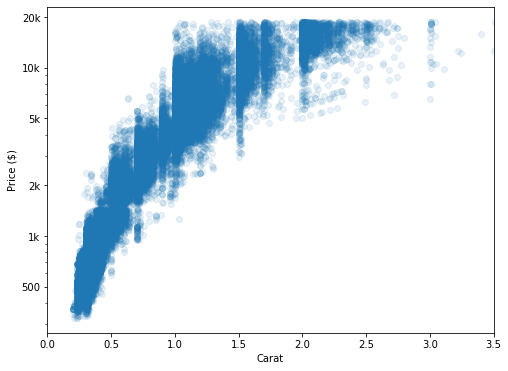

In [32]:
# scatter plot of price vs. carat, with log transform on price axis

plt.figure(figsize=[8, 6])
plt.scatter(data=diamonds, x='carat', y='price', alpha=1/10)
plt.xlim([0,3.5])
plt.xlabel('Carat')
plt.yscale('log')
plt.yticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.ylabel('Price ($)')
plt.show()

This plot suggests from the concavity that we might want to also transform the 'carat' variable to see a linear trend. There also appears to be a price ceiling in the data: given the spread of prices for carat values less than 1.5, we'd expect the prices to be more spread out for carat sizes greater than 1.5 and to see diamonds of value higher than $20k.

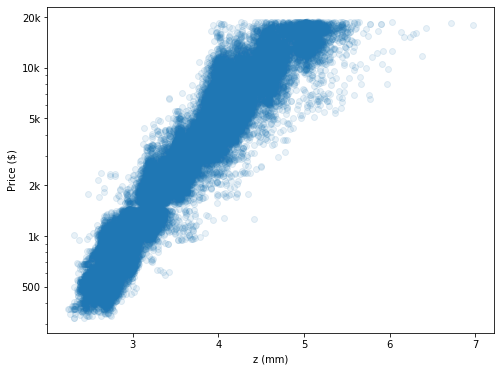

In [33]:
# since x, y and z have a polynomial relationship with carat, let's see how one of them correlates with price.

plt.figure(figsize=[8, 6])
plt.scatter(data=diamonds, x='z', y='price', alpha=1/10)
plt.xlabel('z (mm)')
plt.yscale('log')
plt.yticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.ylabel('Price ($)')
plt.show();

Plotting one of the size dimensions against price generates a relationship that looks much more linear. I'll write a function to perform the cube root and its inverse (just cubing) so I can create this kind of plot on carat. Carat is preferable to 'x', 'y', or 'z' for its general audience interpretability.

In [36]:
def cuberoot_trans(x, inverse = False):
    """ Quick function for computing cube root and cube operations. """
    if not inverse:
        return x ** (1/3)
    else:
        return x ** 3

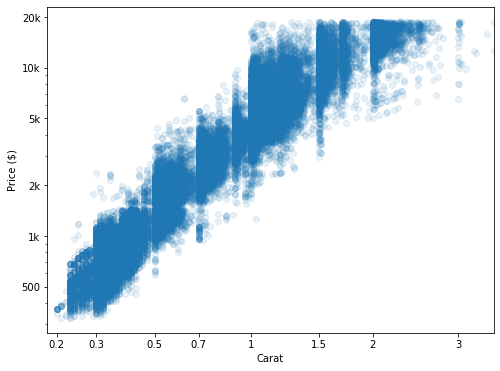

In [37]:
# scatter plot of price vs carat, with log transform on price axis and cube-root transform on price

diamonds['cr_carat'] = diamonds['carat'].apply(cuberoot_trans)

plt.figure(figsize=[8,6])
plt.scatter(data=diamonds, x='cr_carat', y='price', alpha=1/10)

carat_ticks = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
plt.xticks(cuberoot_trans(np.array(carat_ticks)), carat_ticks)
plt.xlim([cuberoot_trans(.18), cuberoot_trans(3.5)])
plt.xlabel('Carat')

plt.yscale('log')
plt.yticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.ylabel('Price ($)')

plt.show();

Now, let's take a second look at the price and carat distributions on the three categorical variables: cut, color and clarity.

In [38]:
# computer the logarithm of price to make multivariate plotting easier
def log_trans(x, inverse=False):
    """ Quick function for computing log and power operations. """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
diamonds['log_price'] = diamonds['price'].apply(log_trans)

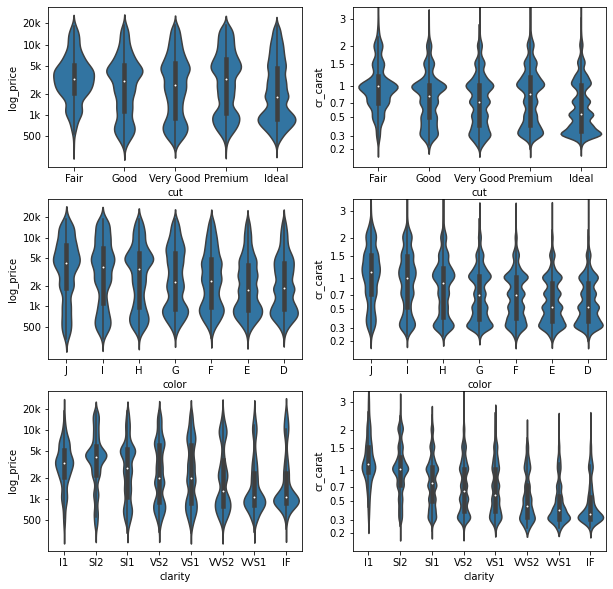

In [44]:
# plot the categorical variables against price and carat again, this time with full data and variabl transforms

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=[10,10])

for i in range(len(categoric_vars)):
    var = categoric_vars[i]
    sb.violinplot(data=diamonds, x=var, y='log_price', ax=ax[i,0], color=base_color)
    ax[i,0].set_yticks(log_trans(np.array([500, 1e3, 2e3, 5e3, 1e4, 2e4])))
    ax[i,0].set_yticklabels([500, '1k', '2k', '5k', '10k', '20k'])
    
    sb.violinplot(data=diamonds, x=var, y='cr_carat', ax=ax[i,1], color=base_color)
    ax[i,1].set_yticks(cuberoot_trans(np.array(carat_ticks)))
    ax[i,1].set_yticklabels(carat_ticks)
    ax[i,1].set_ylim(cuberoot_trans(np.array([0.1, 3.5])))
    
plt.show();

The plot of full data using a violin plot and variable transformations reveals much more than the earlier box plots. It is highly suggested that the decrease in average price across increasing quality is due to the average diamond size decreasing with increasing quality. This is clearest in the plots across clarity, moderately visible with cut, and least evident with color. It will be interesting to see how the categories map in the multivariate analysis.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Price had a surprisingly high amount of correlation with the diamond size, even before transforming the features. An approximately linear relationship was observed when price was plotted on a log scale and carat was plotted with a cube-root transform. The scatterplot that came out of this also suggested that there was an upper bound on the diamond prices available in the dataset, since the range of prices for the largest diamonds was much narrower than ould have been expected, based on the price ranges of smaller diamonds. <br/>

There was also an interesting relationship observed between price and the categorical features. For all of cut, color, and clarity, lower prices were associated with increasting quality. One of the potentially major interacting factors is the fact that improved quality levels were also associated with smaller diamonds. This will have to be explored further in the next section.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Expected relationships were found in the association between the 'x', 'y' and 'z' measurements of diamonds to the other linear dimensions as well as to the 'carat' variable. A small negative correlation was observed between table size and depth, but neither of these variables show a strong correlation with price, so they won't be explored further. There was also a small interaction in the categorical quality features. Diamonds of lower clarity appear to have slightly better cut and color grades.

## Multivariate Exploration

The main thing I want to explore in this part of the analysis is how the three categorical measures of quality play into the relationship between price and carat.

In [46]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    bins_x = np.arange(cuberoot_trans(.2), cuberoot_trans(3.5) + .05, .05)
    bins_y = np.arange(2.4, 4.3+0.1, 0.1)
    plt.hist2d(x, y, bins=[bins_x, bins_y], cmap=palette, cmin=0.5)
    plt.xticks(cuberoot_trans(np.array(carat_ticks)), carat_ticks)
    plt.yticks(log_trans(np.array([500, 1e3, 2e3, 5e3, 1e4, 2e4])), [500, '1k', '2k', '5k', '10k', '20k'])

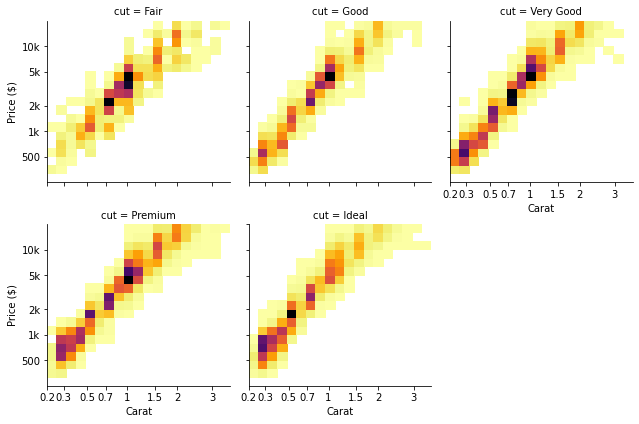

In [50]:
# Create faceted heap maps on levels of the cut variable
g = sb.FacetGrid(data=diamonds, col='cut', col_wrap=3, size=3, xlim=[cuberoot_trans(.18), cuberoot_trans(3.5)])
g.map(hist2dgrid, 'cr_carat', 'log_price', color='inferno_r')
g.set_xlabels('Carat')
g.set_ylabels('Price ($)')

plt.show();

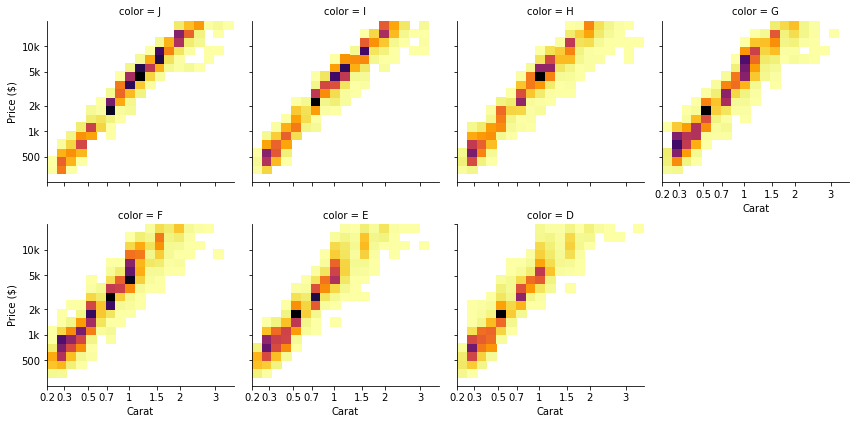

In [52]:
# Create faceted heap maps on levels of the color variable
g = sb.FacetGrid(data=diamonds, col='color', col_wrap=4, size=3, xlim=[cuberoot_trans(.18), cuberoot_trans(3.5)])
g.map(hist2dgrid, 'cr_carat', 'log_price', color='inferno_r')
g.set_xlabels('Carat')
g.set_ylabels('Price ($)')

plt.show();

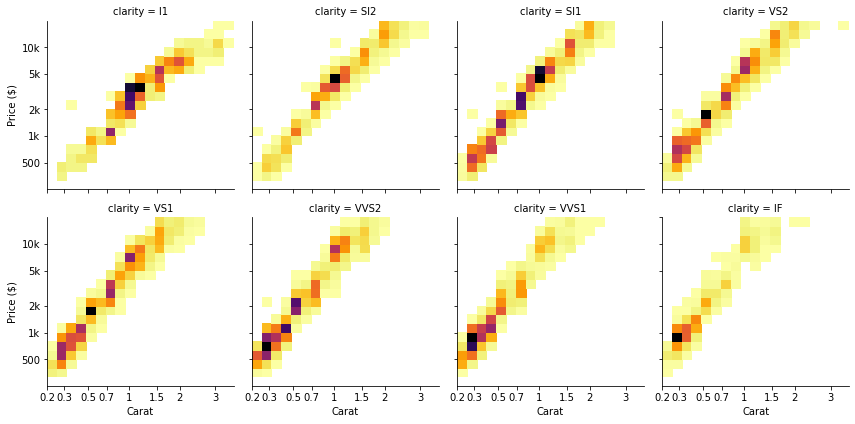

In [53]:
# Create faceted heap maps on levels of the clarity variable
g = sb.FacetGrid(data=diamonds, col='clarity', col_wrap=4, size=3, xlim=[cuberoot_trans(.18), cuberoot_trans(3.5)])
g.map(hist2dgrid, 'cr_carat', 'log_price', color='inferno_r')
g.set_xlabels('Carat')
g.set_ylabels('Price ($)')

plt.show();

In each of the faceted heat maps, you can see the relationship of quality level against price and diamond size, to varying levels of effectiveness. As the quality level increases, the 'cloud' of points moves towards the upper left of the plot, thus showing increased prices but also smaller diamonds. This is the clearest in the clarity plot.

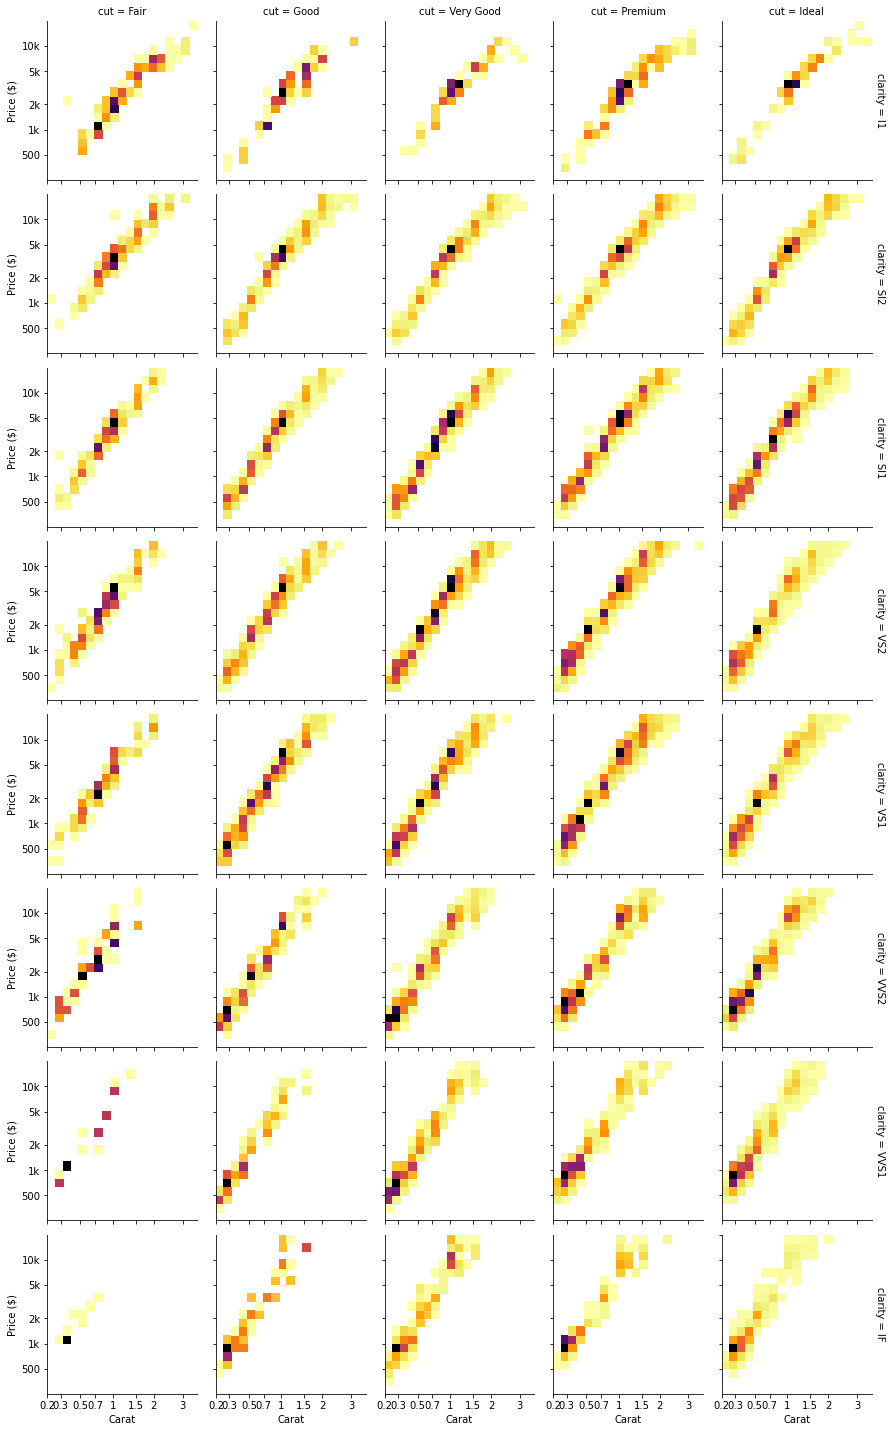

In [54]:
# create faceted heat maps on levels of cut and clairty
g = sb.FacetGrid(data=diamonds, col='cut', row='clarity', size=2.5, 
                 xlim=[cuberoot_trans(.18), cuberoot_trans(3.5)], margin_titles = True)
g.map(hist2dgrid, 'cr_carat', 'log_price', color='inferno_r')
g.set_xlabels('Carat')
g.set_ylabels('Price ($)')

plt.show();

I tried looking at the faceted heat map across two quality dimensions, but it seems like there's too many facets to look at. Perhaps a better summary can come from looking at only diamonds of a specific carat size.

In [71]:
# select diamonds of approximately 1 carat
diamond_flag = (diamonds['carat'] >= 0.99) & (diamonds['carat'] <= 1.03)
diamonds_1c = diamonds.loc[diamond_flag, :]

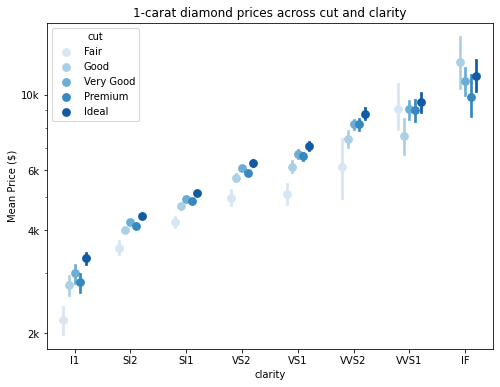

In [72]:
fig = plt.figure(figsize = [8, 6])
ax = sb.pointplot(data=diamonds_1c, x='clarity', y='price', hue='cut', 
                  palette='Blues', linestyles='', dodge=0.4)
plt.title('1-carat diamond prices across cut and clarity')
plt.ylabel('Mean Price ($)')
plt.yscale('log')
plt.yticks([2e3, 4e3, 6e3, 1e4], ['2k', '4k', '6k', '10k'])
ax.set_yticklabels([], minor=True)
plt.show()

A dodged point plot for diamonds of approximately 1 carat in size shows the clear influence of clarity and cut on diamond price. The larger error bars on the right side are due to there being fewer diamonds at higher clarity grades at this diamond size. There also appear to be fewer diamonds of grade 'Fair' on the higher clarity grades, with none on the highest 'IF' rating.

In [73]:
# select diamonds of approximately 0.3 carat
diamond_flag = (diamonds['carat'] >= 0.29) & (diamonds['carat'] <= 0.33)
diamonds_sml = diamonds.loc[diamond_flag, :]

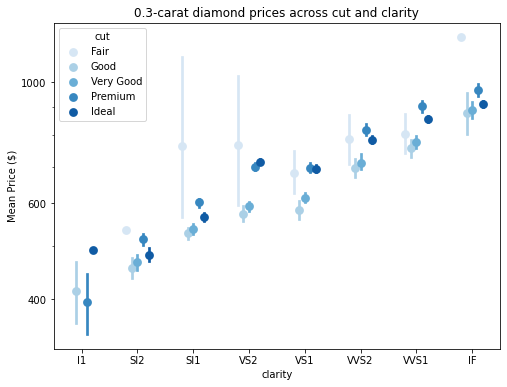

In [76]:
fig = plt.figure(figsize = [8, 6])
ax = sb.pointplot(data=diamonds_sml, x='clarity', y='price', hue='cut', 
                  palette='Blues', linestyles='', dodge=0.4)
plt.title('0.3-carat diamond prices across cut and clarity')
plt.ylabel('Mean Price ($)')
plt.yscale('log')
plt.yticks([4e2, 6e2, 1e3], ['400', '600', '1000'])
ax.set_yticklabels([], minor=True)
plt.show()

The plot is less clear for the smaller diamonds around 0.3 carat. There are few diamonds in the lower clarity grades and more on the high-clarity grades at this diamond size. Interestingly, diamonds of the 'Fair' cut grade are generally higher-priced than the 'Good' and 'Very Good' cuts, but there's no good explanation for this from this plot.

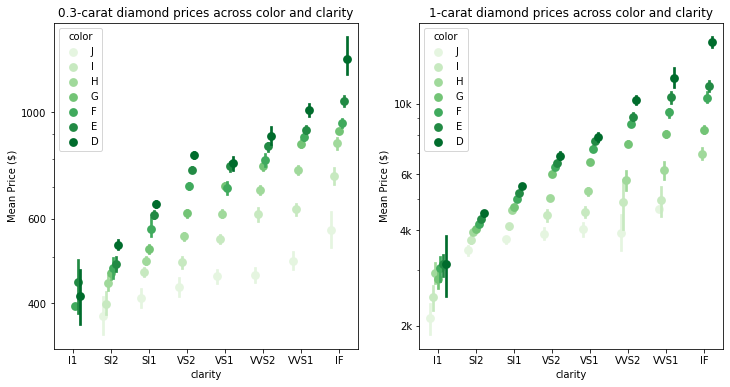

In [81]:
fig, ax = plt.subplots(ncols = 2, figsize=[12,6])

sb.pointplot(data=diamonds_sml, x='clarity', y='price', hue='color', 
             palette='Greens', linestyles='', dodge=0.4, ax=ax[0])
ax[0].set_title('0.3-carat diamond prices across color and clarity')
ax[0].set_ylabel('Mean Price ($)')
ax[0].set_yscale('log')
ax[0].set_yticks([400,600,1000])
ax[0].set_yticklabels(['400', '600', '1000'])
ax[0].set_yticklabels([], minor=True)

sb.pointplot(data=diamonds_1c, x='clarity', y='price', hue='color', 
             palette='Greens', linestyles='', dodge=0.4, ax=ax[1])
ax[1].set_title('1-carat diamond prices across color and clarity')
ax[1].set_ylabel('Mean Price ($)')
ax[1].set_yscale('log')
ax[1].set_yticks([2e3,4e3,6e3,1e4])
ax[1].set_yticklabels(['2k', '4k', '6k', '10k'])
ax[1].set_yticklabels([], minor=True)

plt.show()

The hierarchy in pricing by color is clear when clustered across clarity values. The pattern looks more systematic than the "cut by clarity" pointplots.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I extended my investigation of price against diamond size in this section by looking at the impact of the three categorical quality features. The multivariate exploration here showed that there indeed is a positive effect of increased quality grade on diamond price, but in the dataset, this is initially hidden by the fact that higher grades were more prevalent in smaller diamonds, which fetch lower prices overall. Controlling for the carat weight of a diamond shows the effect of the other C's of diamonds more clearly. This effect was clearest for the color and clarity variables, with less systematic trend for cut.

### Were there any interesting or surprising interactions between features?

Looking back on the point plots, it doesn't seem like there's a systematic interaction effect between the three categorical features. However, the features also aren't fully independent. But it is interesting in something like the 1-carat plot for prices against cut and clarity, the shape of the 'cut' dots is fairly similar for the SI1 through VVS2 clarity levels.